In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import json

## Create Database Connection

In [19]:
def create_db_connection():
    con = sqlite3.connect('ibm_real_device_run_results.db')
    return con

def drop_table(con):
    cur = con.cursor()
    sql = '''
            DROP TABLE run_data
          '''
    cur.execute(sql)
    con.commit()

def create_table(con):
    cur = con.cursor()
    
    # counts_experimental = counts with error on real device
    # counts_ideal = counts without error on real device
    # counts_noisy_simulation = counts with error on simulator
    
    sql = '''
            CREATE TABLE IF NOT EXISTS run_data (id INTEGER PRIMARY KEY AUTOINCREMENT, backend TEXT, state_name TEXT, 
            tvd REAL, jsd REAL, hellinger REAL, counts_experimental TEXT, counts_ideal TEXT, counts_simulation TEXT)
          '''
    cur.execute(sql)
    con.commit()
    
def insert_into_table(con, backend, state_name, tvd, jsd, hellinger, counts_experimental, counts_ideal, counts_simulation):
    cur = con.cursor()
    sql = '''
            INSERT INTO run_data (backend, state_name, tvd, jsd, 
            hellinger, counts_experimental, counts_ideal, counts_simulation) 
            VALUES ("{}", "{}", {}, {}, {}, "{}", "{}", "{}")
          '''.format(backend, state_name, tvd, jsd, hellinger, counts_experimental, counts_ideal, counts_simulation)
    cur.execute(sql)
    con.commit()
    
def show_table_data(con):
    cur = con.cursor()
    sql = '''
            SELECT * FROM run_data
          '''
    res = cur.execute(sql)
    return res.fetchall()
    
def check_data_for_some_backend_and_state_exists(con, backend, state_name):
    cur = con.cursor()
    cur.execute("SELECT id FROM run_data WHERE backend = ? AND state_name = ?", (backend, state_name))
    data = cur.fetchall()
    
    if len(data) == 0:
        return False
    return True

def search_data(con, backend, state_name):
    cur = con.cursor()
    cur.execute("SELECT * FROM run_data WHERE backend = ? AND state_name = ?", (backend, state_name))
    data = cur.fetchall()
    
    return data

def create_column():
    con = create_db_connection()
    sql = ''' ALTER TABLE run_data ADD COLUMN qubits INT '''
    cur = con.cursor()
    cur.execute(sql)
    con.commit()
    con.close()

## Load Data

In [31]:
con = create_db_connection()
data = show_table_data(con)

In [14]:
print("hellinger for oslo-ghz: ", search_data(con, 'ibmq_oslo', 'ghz_circ'))

hellinger for oslo-ghz:  [(36, 'ibmq_oslo', 'ghz_circ', 0.07274218750000001, 0.7426715475895849, 0.18570766223742965, "{'000': 1787, '001': 124, '010': 23, '011': 88, '100': 102, '101': 15, '110': 36, '111': 1825}", "({'000': 1787, '001': 124, '010': 23, '011': 88, '100': 102, '101': 15, '110': 36, '111': 1825}, {'011': 12, '101': 14, '110': 9, '000': 521, '111': 468, '001': 0, '010': 0, '100': 0}, {'111': 503, '000': 521, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0})", "{'011': 12, '101': 14, '110': 9, '000': 521, '111': 468, '001': 0, '010': 0, '100': 0}", 3)]


## Generate Plot

In [15]:
def add_missing_states(qubits, counts_experimental, counts_simulation, counts_ideal):
    for number in range(2**qubits):
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in counts_experimental:
            counts_experimental[binary_state] = 0

        if binary_state not in counts_simulation:
            counts_simulation[binary_state] = 0
            
        if binary_state not in counts_ideal:
            counts_ideal[binary_state] = 0
            
    return counts_experimental, counts_simulation, counts_ideal

In [107]:
def generate_plot(qubits, counts_experimental, counts_simulation, counts_ideal, backend_name, circ_name):
    counts_experimental, counts_simulation, counts_ideal = add_missing_states(qubits, counts_experimental, 
                                                                              counts_simulation, counts_ideal)
    counts_ideal = dict(sorted(counts_ideal.items()))
    counts_simulation = dict(sorted(counts_simulation.items()))
    counts_experimental = dict(sorted(counts_experimental.items()))
    
    #Probability Distribution
    s_ideal = sum(counts_ideal.values())
    for key, value in counts_ideal.items():
        percentage = value / s_ideal
        counts_ideal[key] = percentage
        
    s_simulated = sum(counts_simulation.values())
    for key, value in counts_simulation.items():
        percentage = value / s_simulated
        counts_simulation[key] = percentage
        
    s_experimental = sum(counts_experimental.values())
    for key, value in counts_experimental.items():
        percentage = value / s_experimental
        counts_experimental[key] = percentage
    
    fname = f'./Images/Comparison_with_real/{backend_name}_{circ_name}.pdf'
    
    bar_width = 0.5
        
    df = {
        'Experimental Probability': counts_experimental,
        'Simulated Probability': counts_simulation,
        'Ideal Probability': counts_ideal,
    }
    df = pd.DataFrame(df, index=list(counts_experimental.keys()))

    ax = df.plot(figsize=(20,8), kind='bar', width=0.8, fontsize=16)
    ax.set_xlabel("States", fontsize=18)
    ax.set_ylabel("Probability", fontsize=18)
    ax.legend(loc=1,fontsize=20)
    
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [108]:
def convert_string_to_dictionary(string):
    Dict = eval(string)
    return Dict

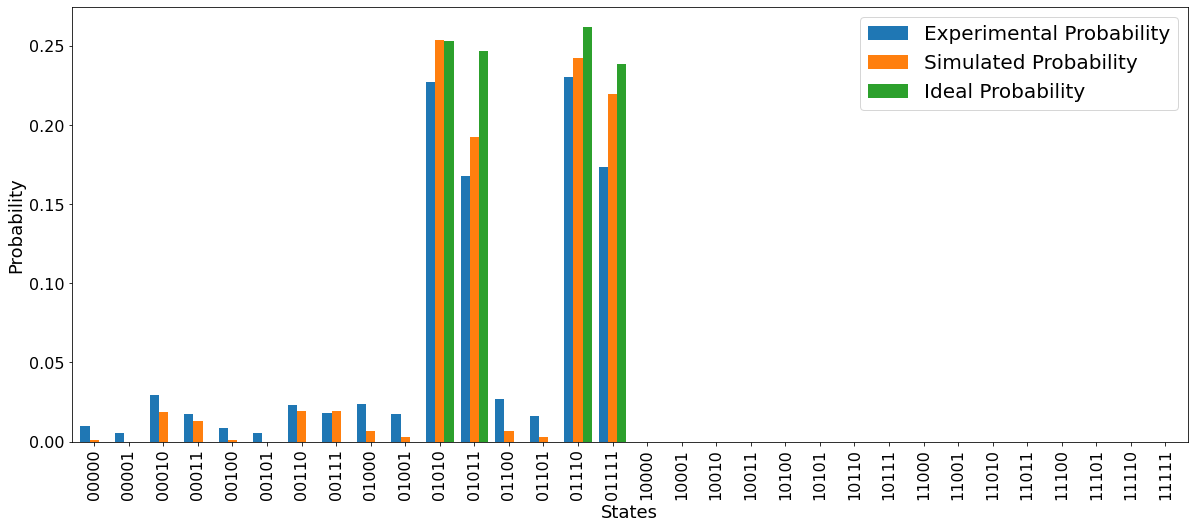

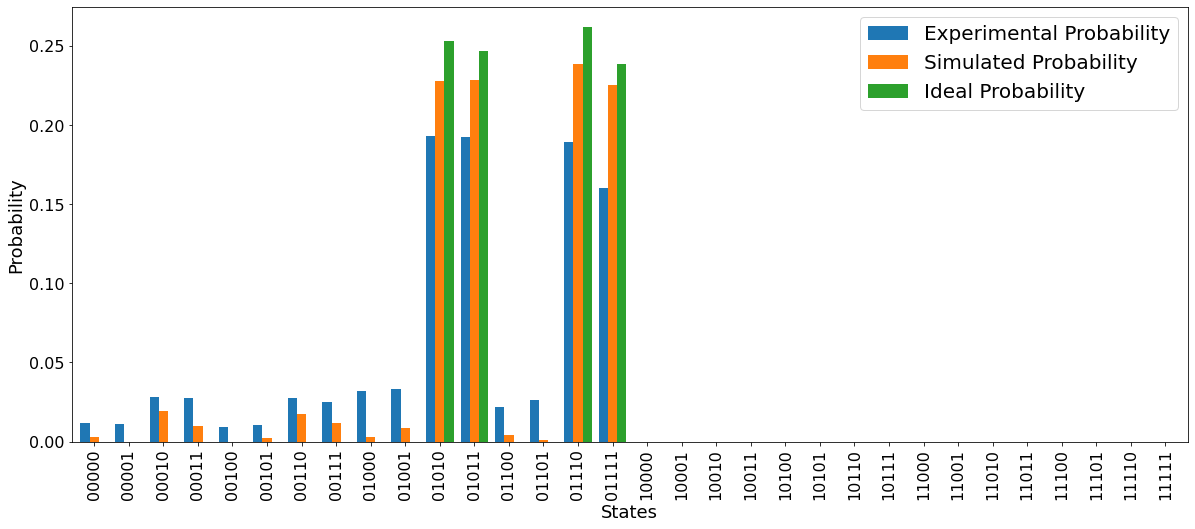

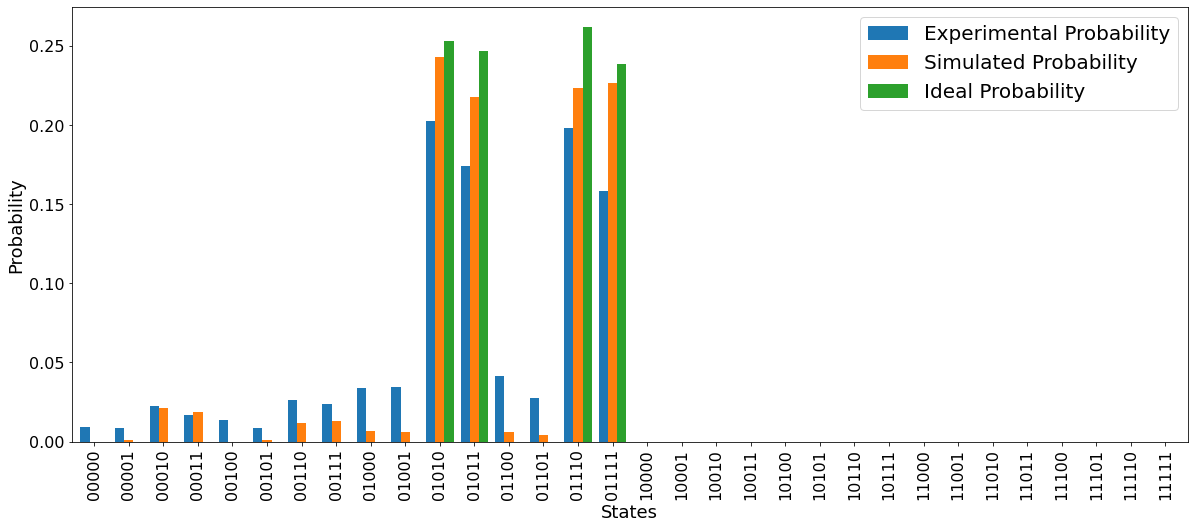

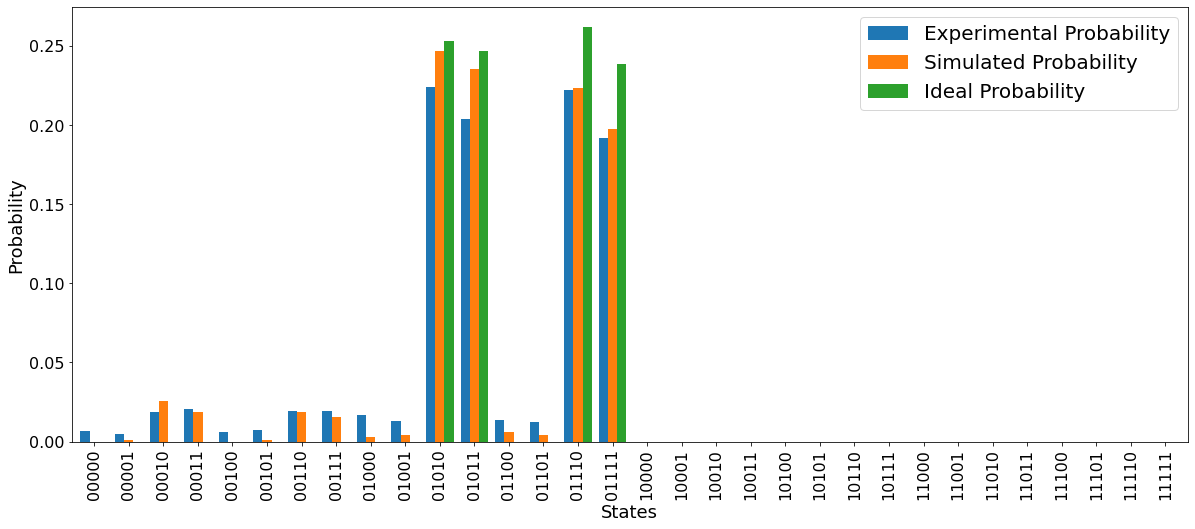

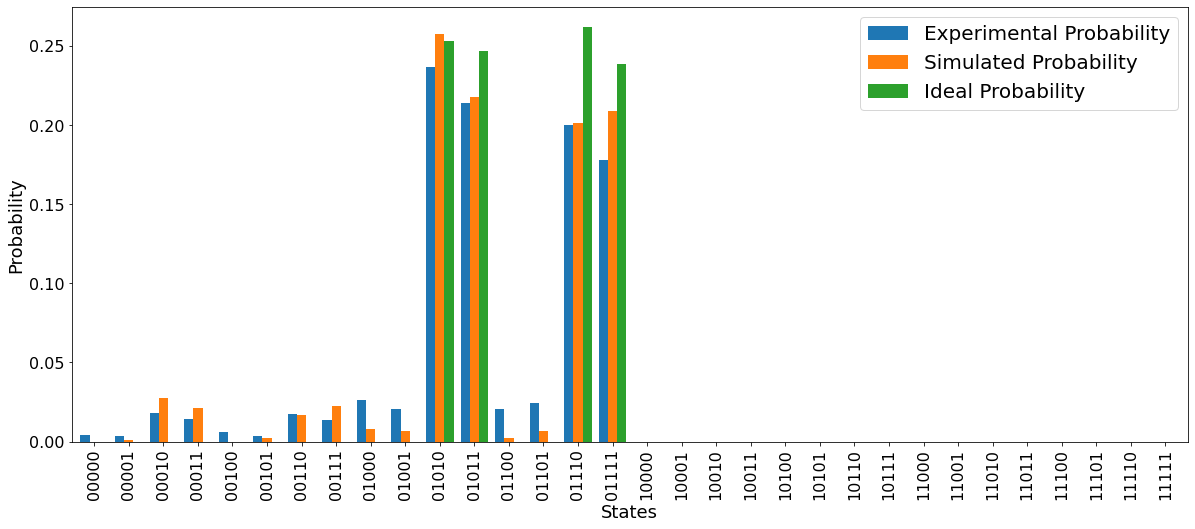

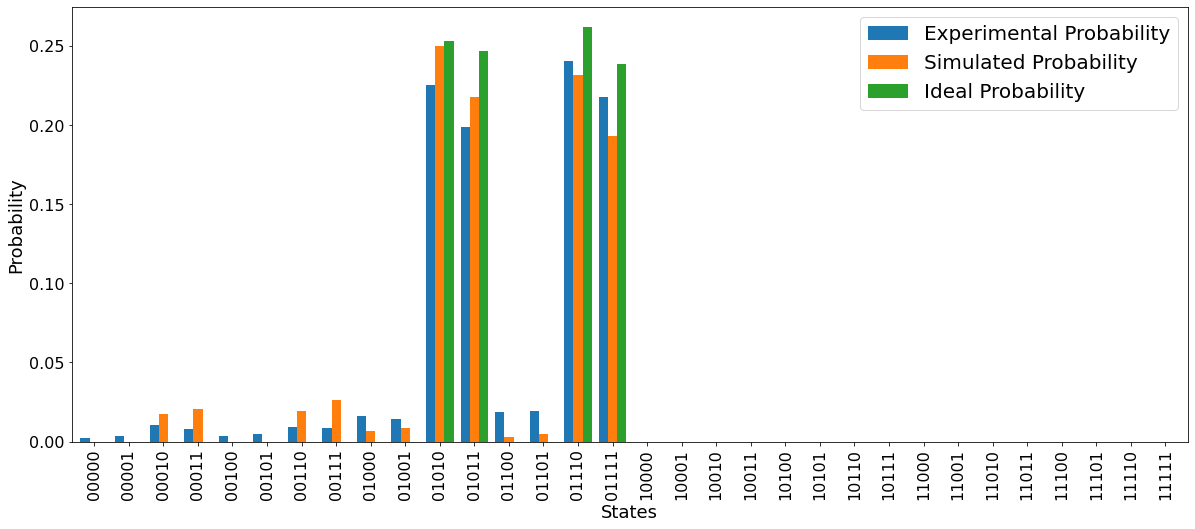

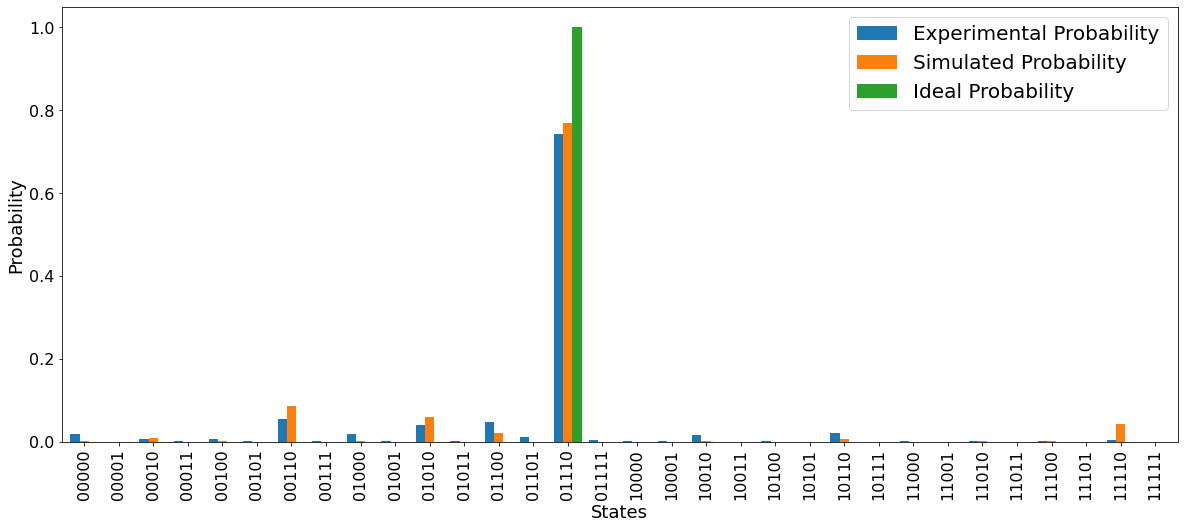

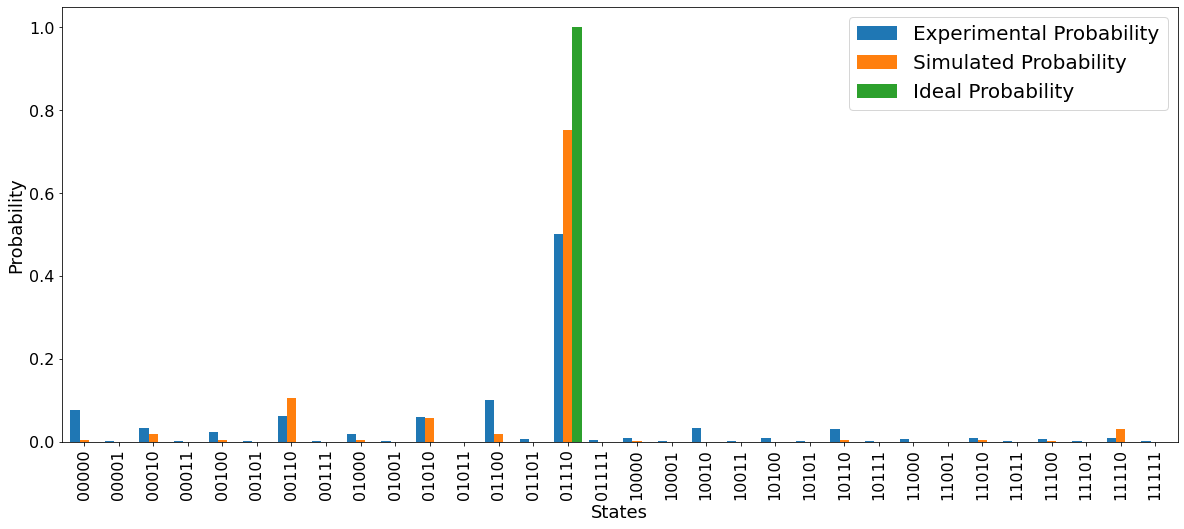

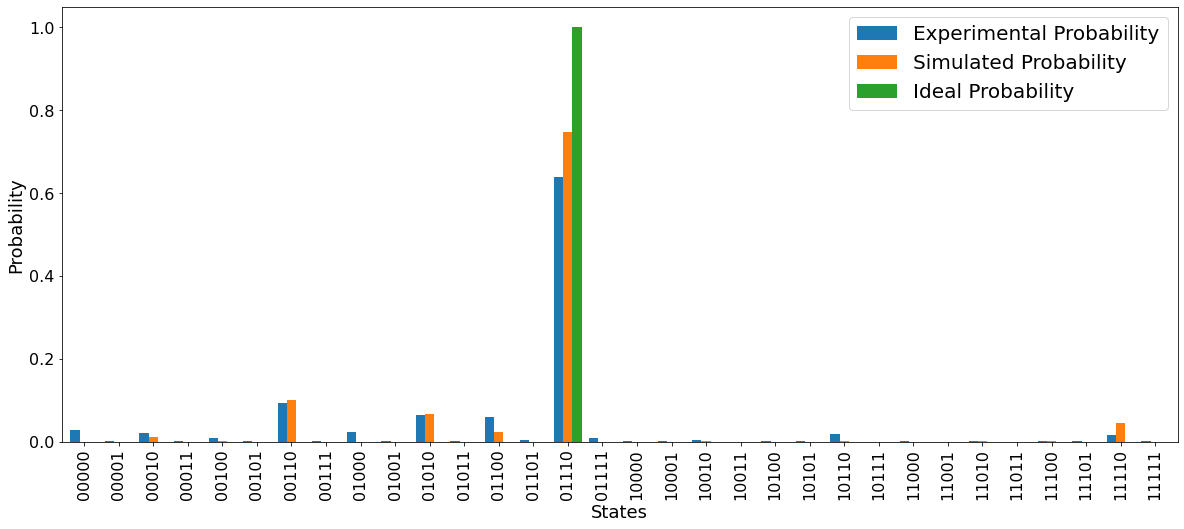

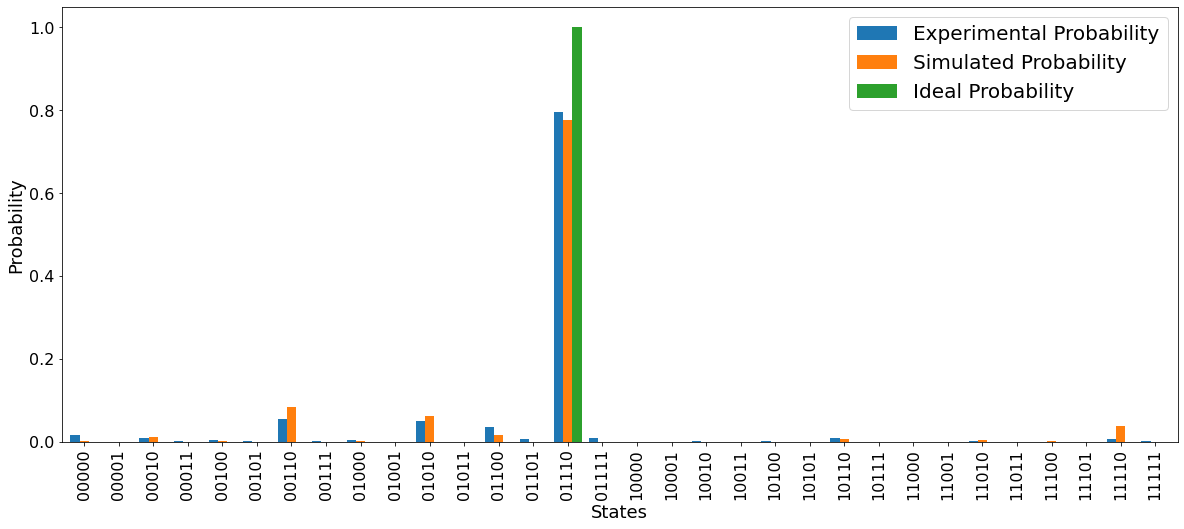

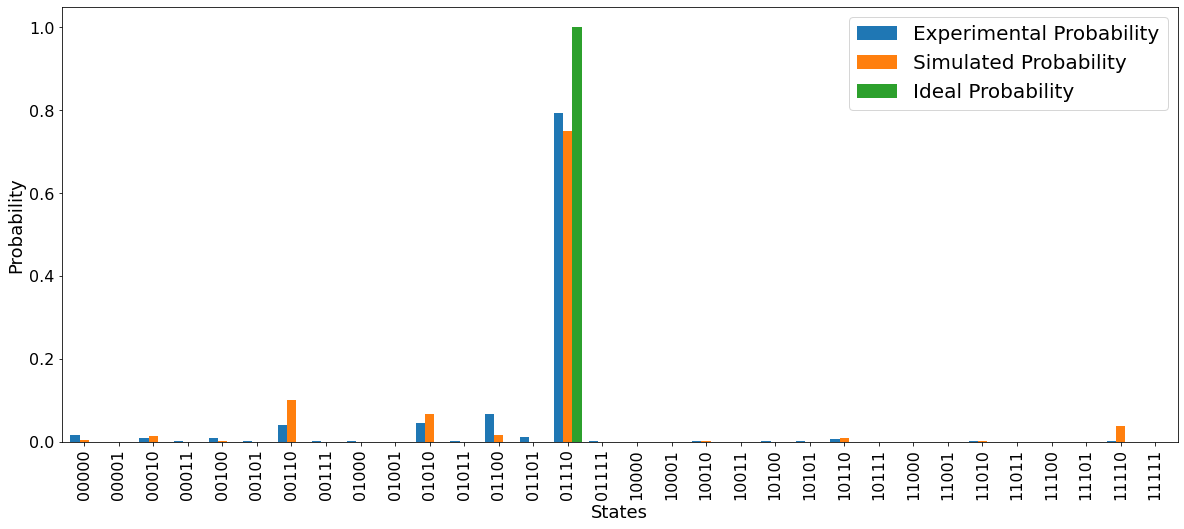

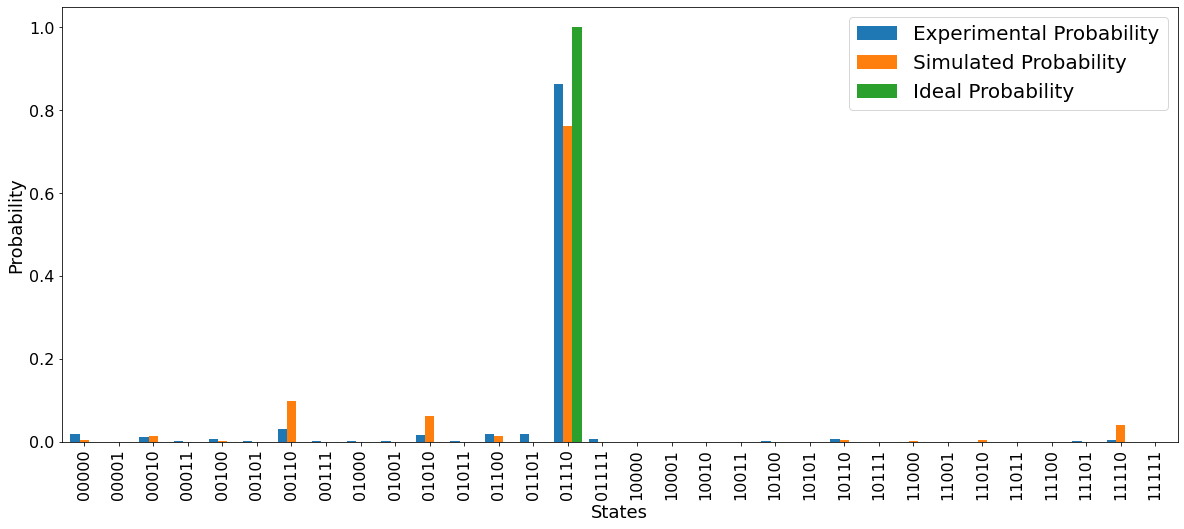

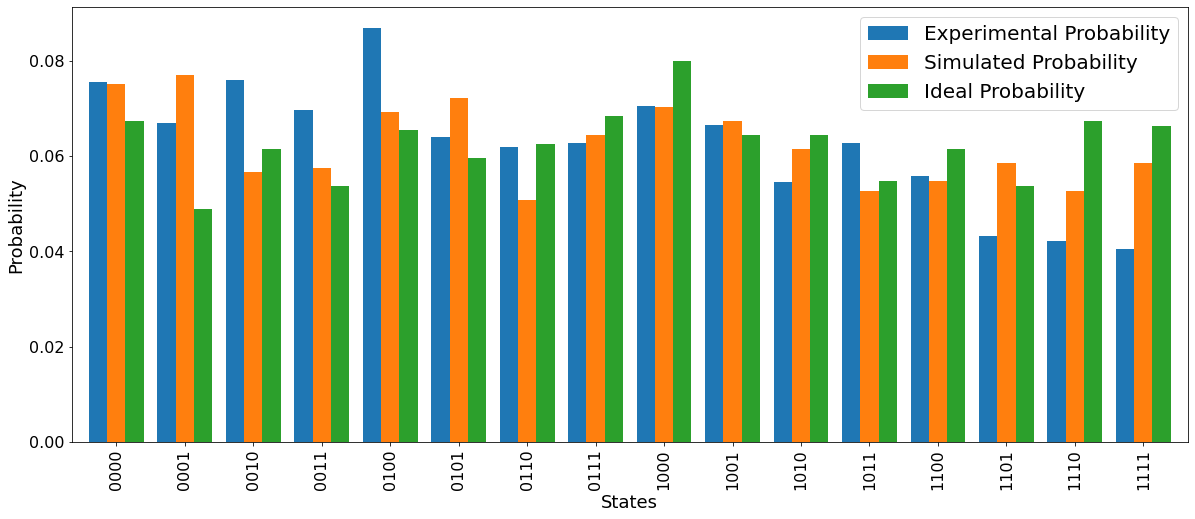

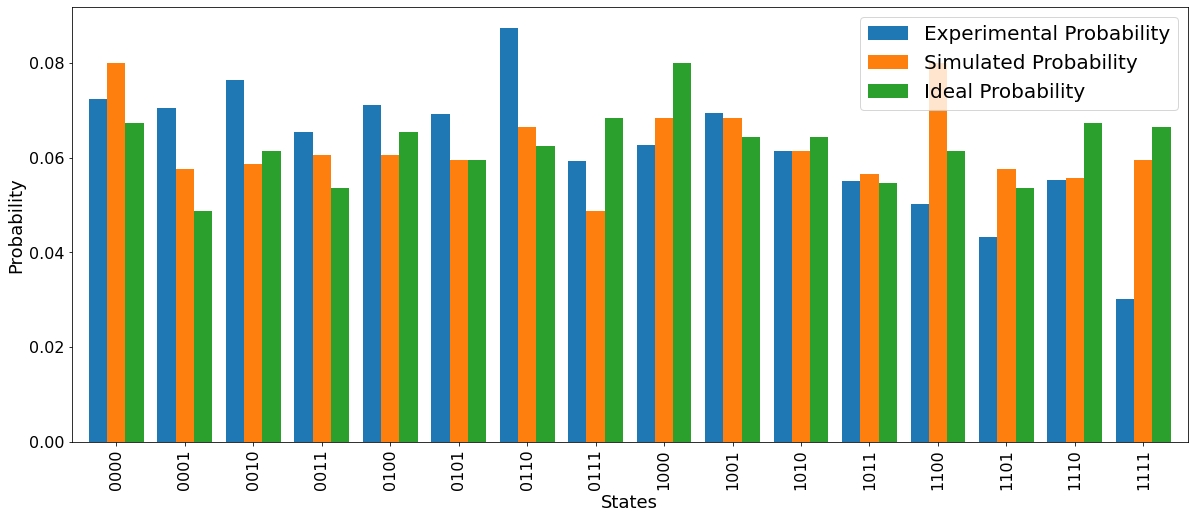

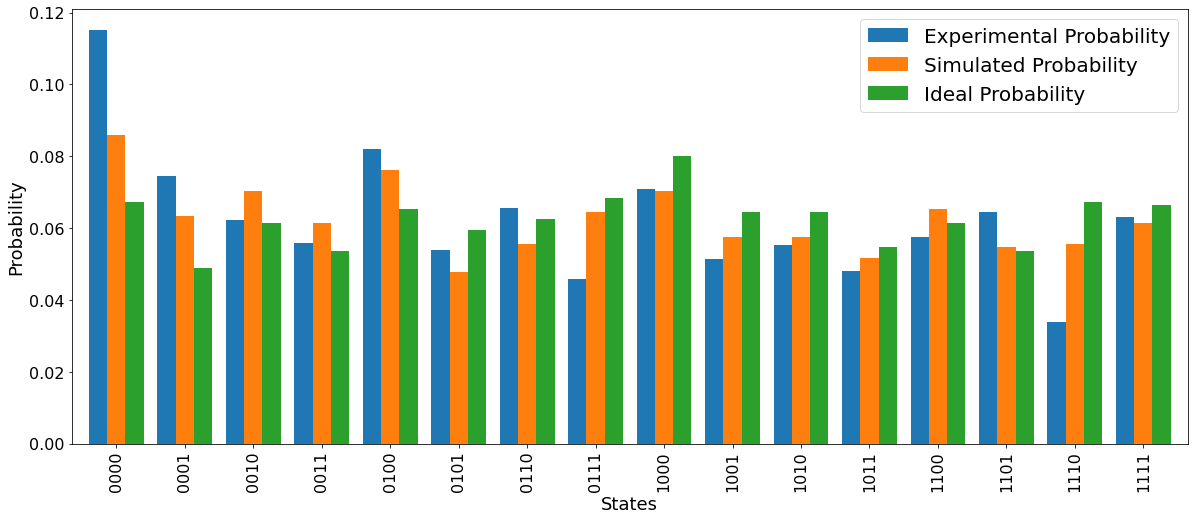

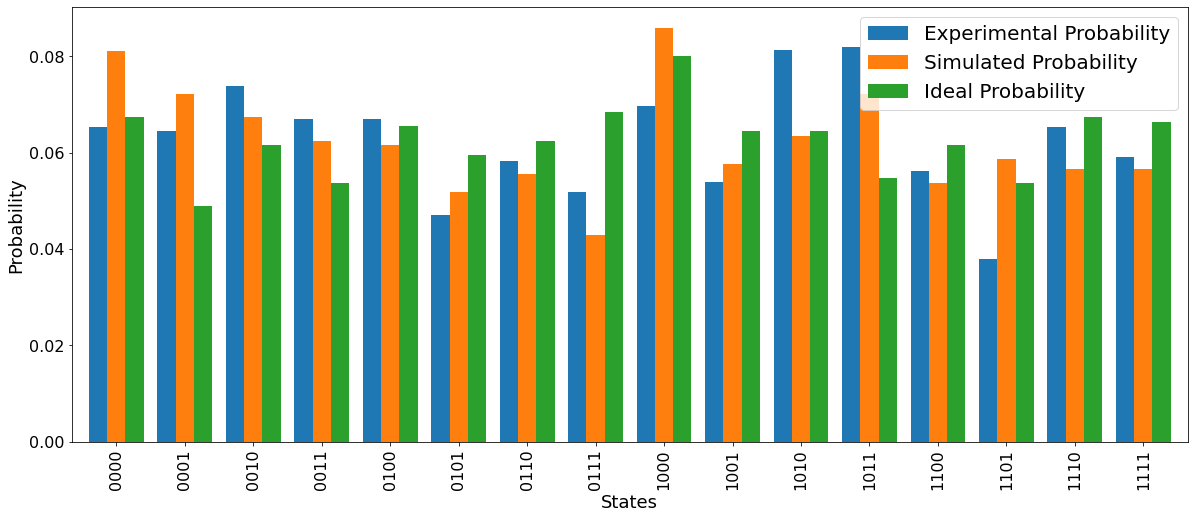

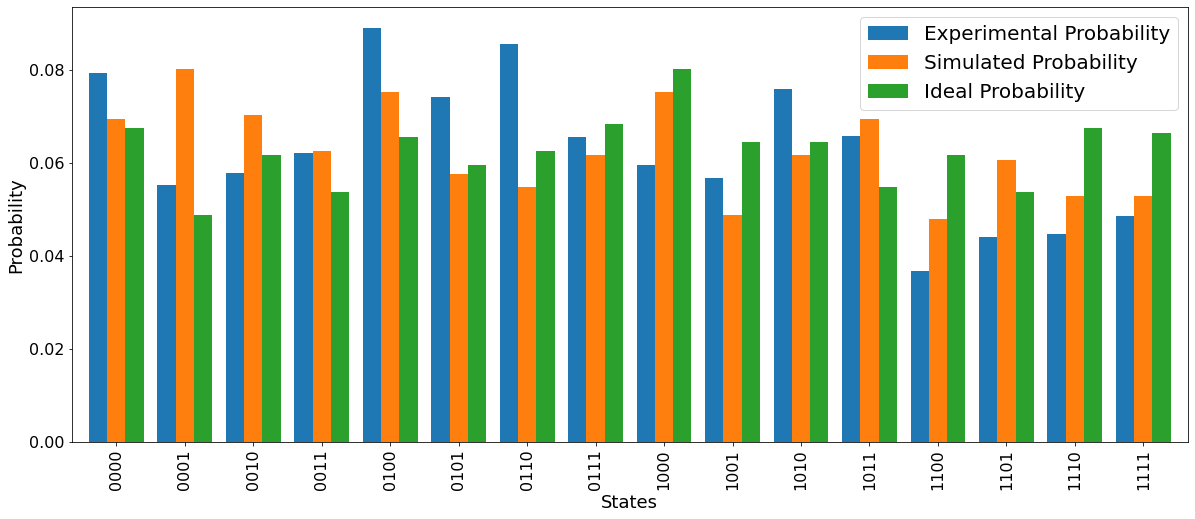

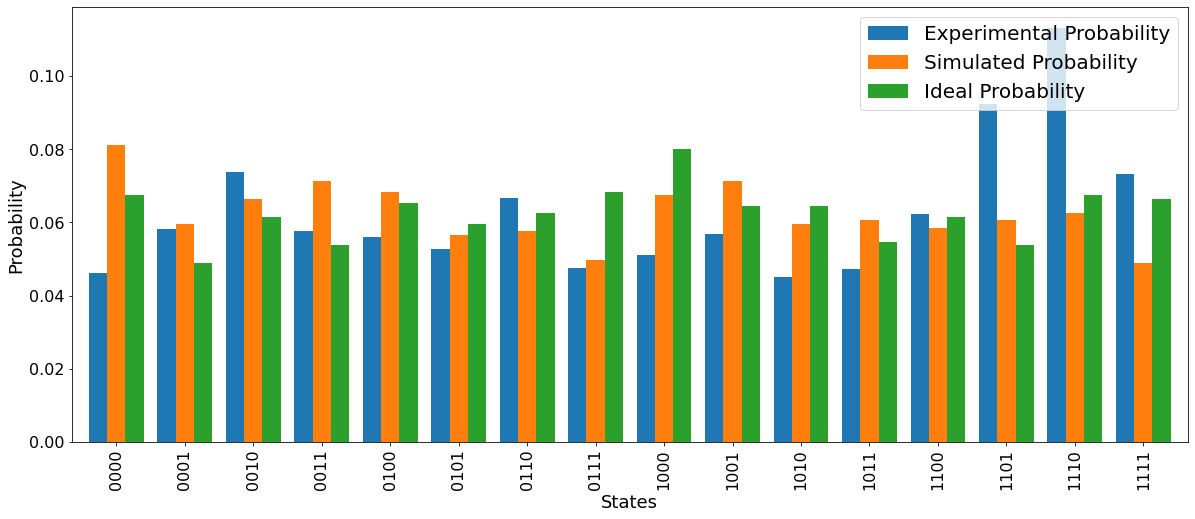

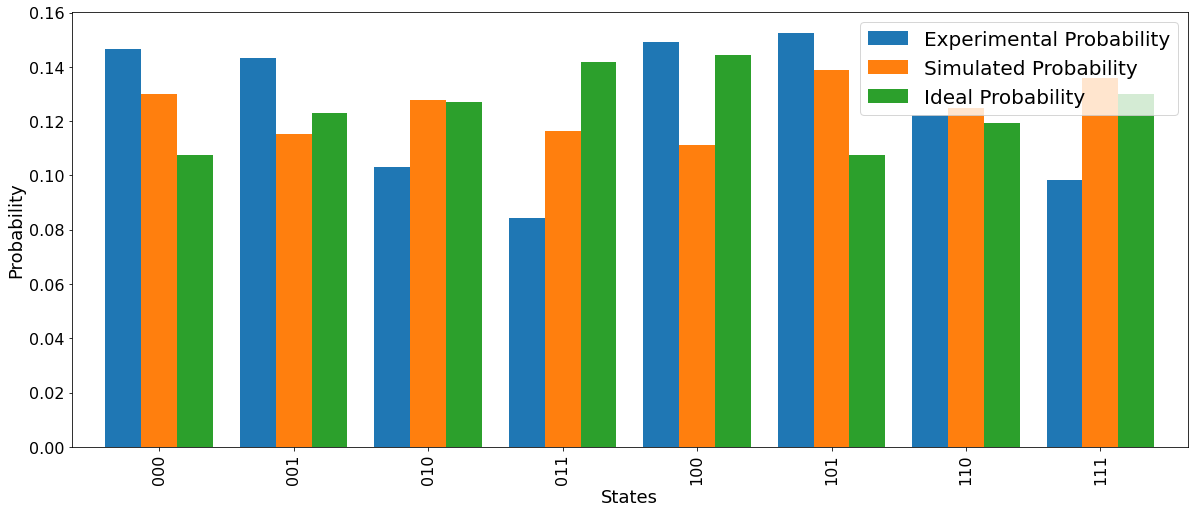

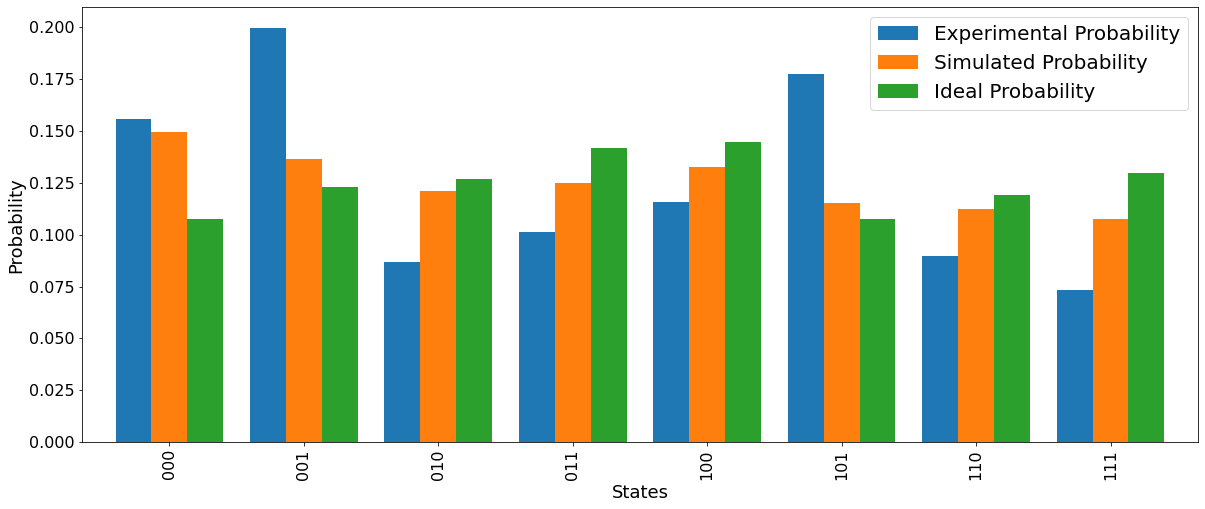

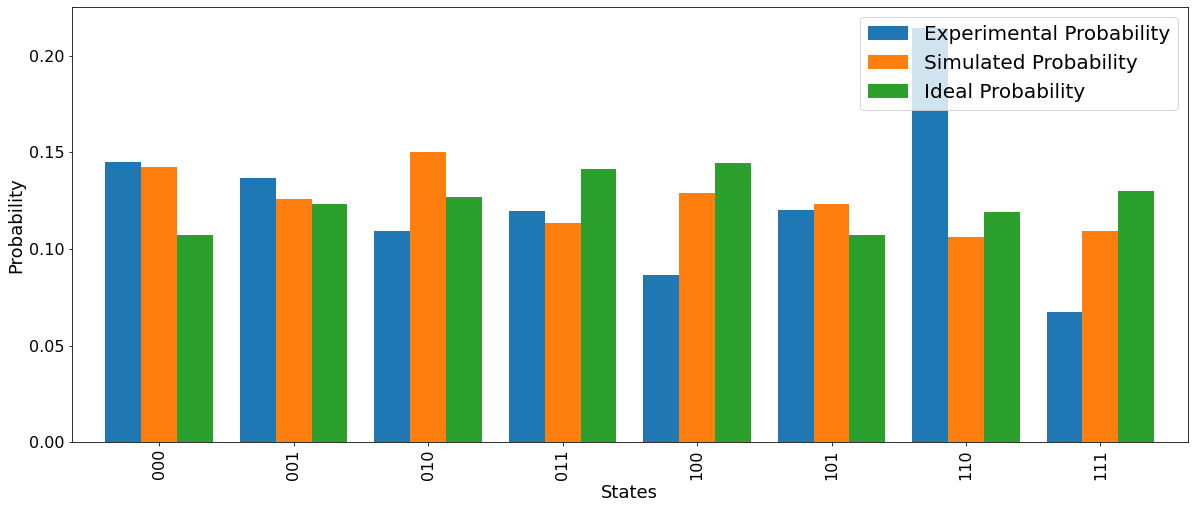

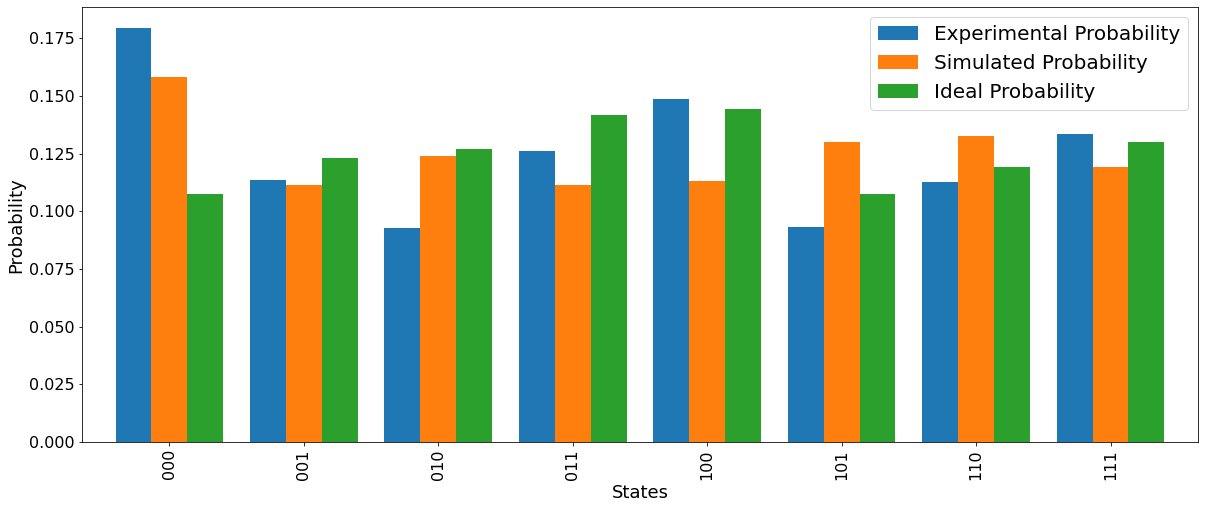

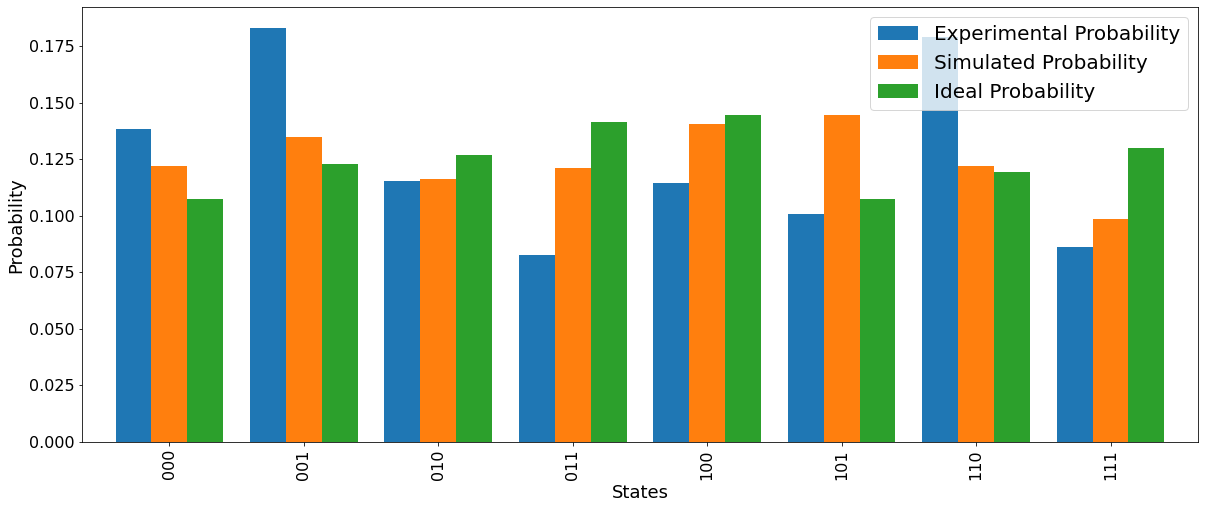

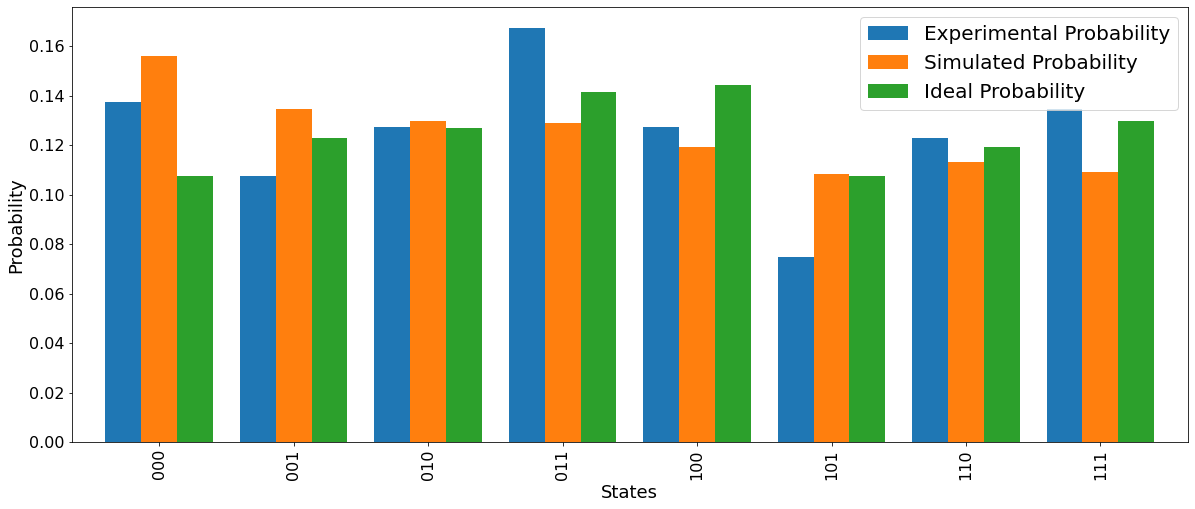

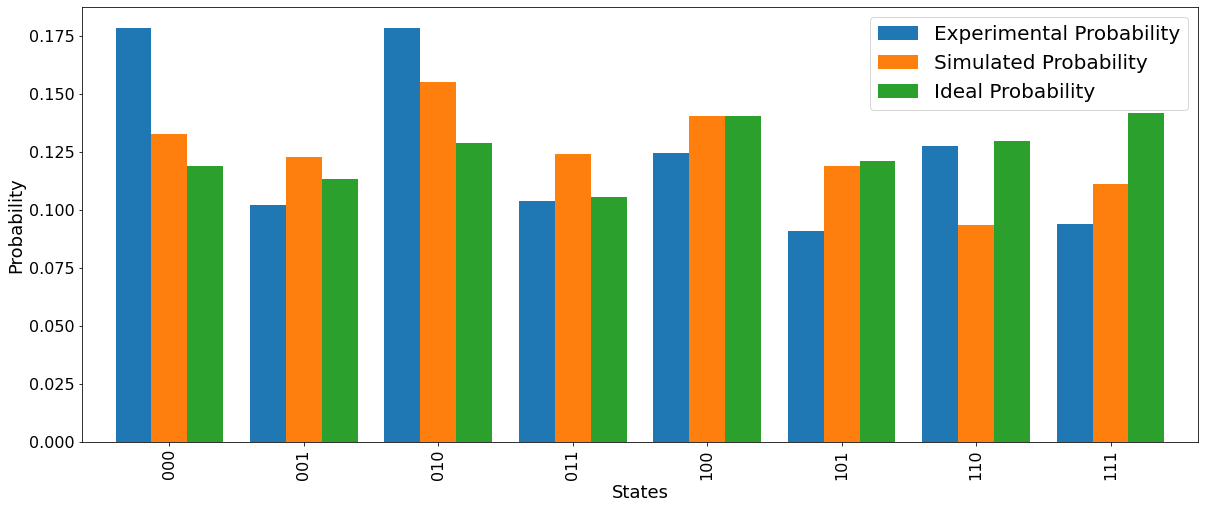

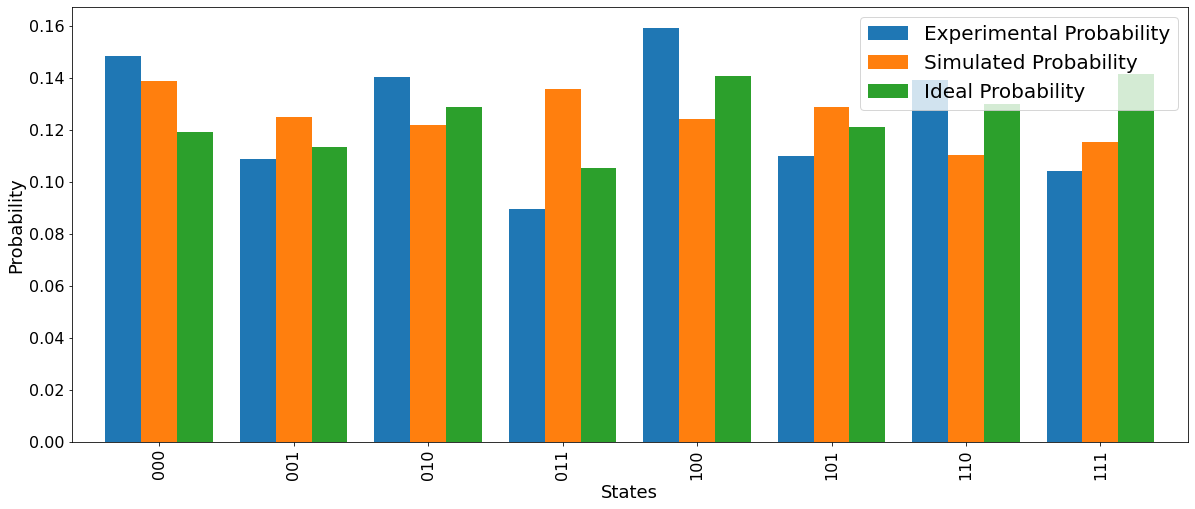

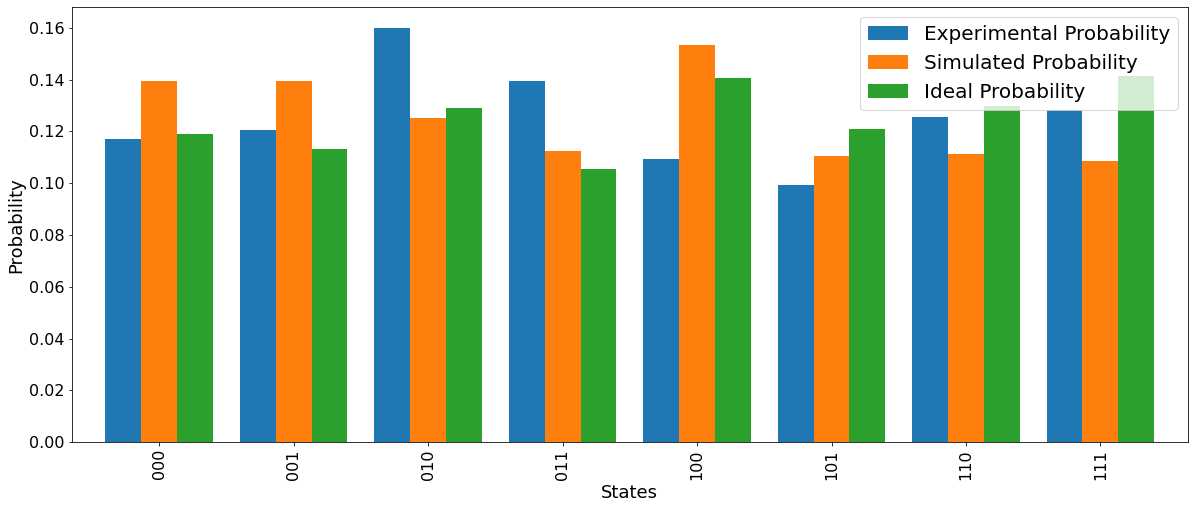

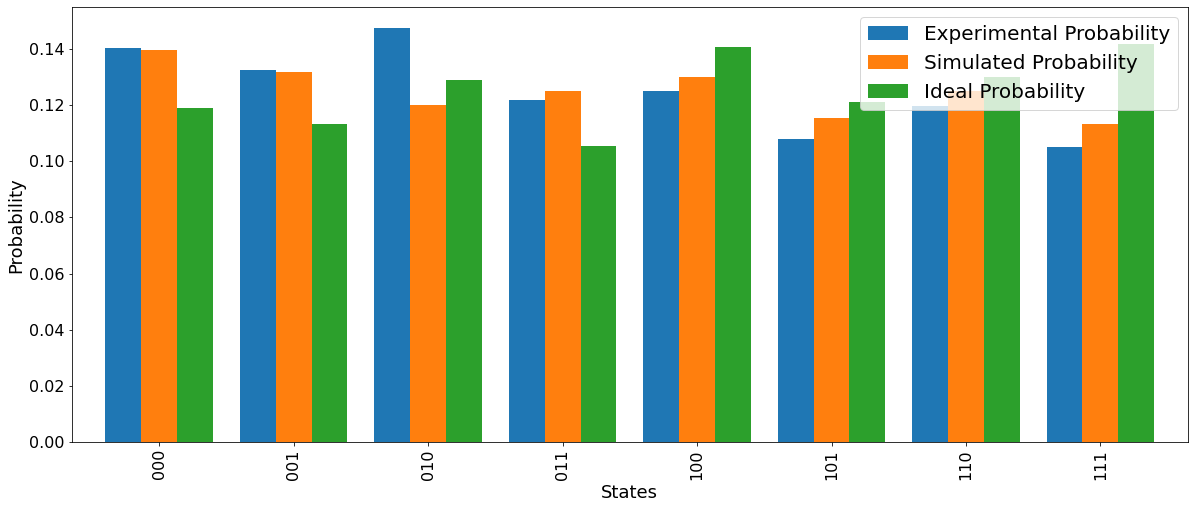

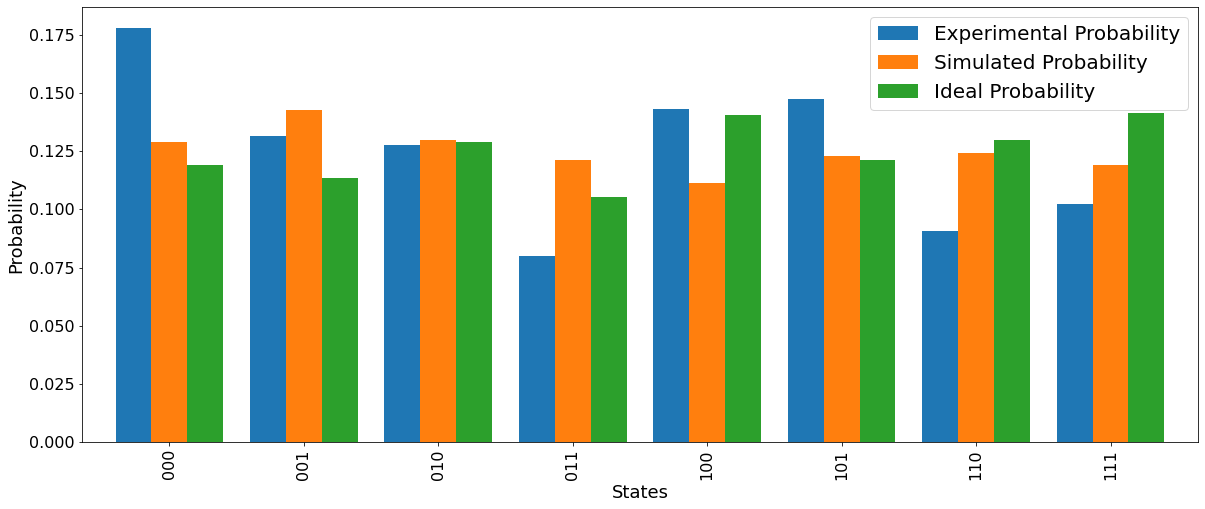

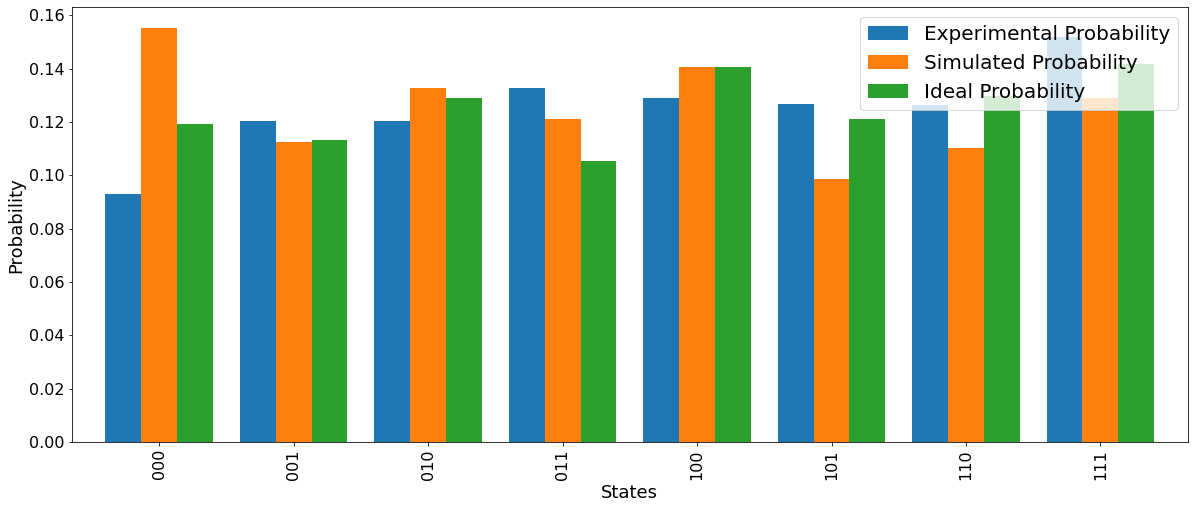

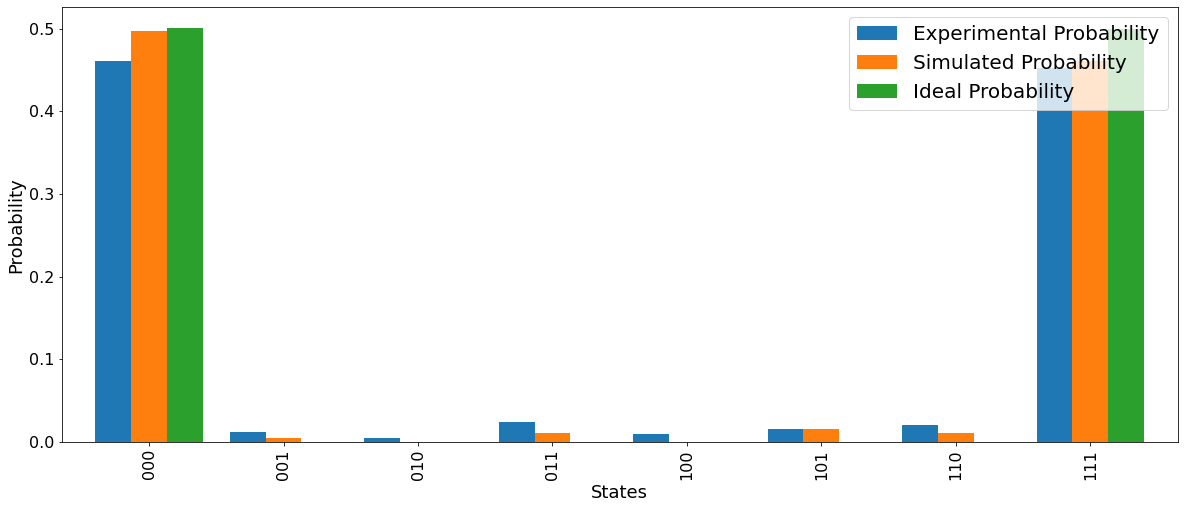

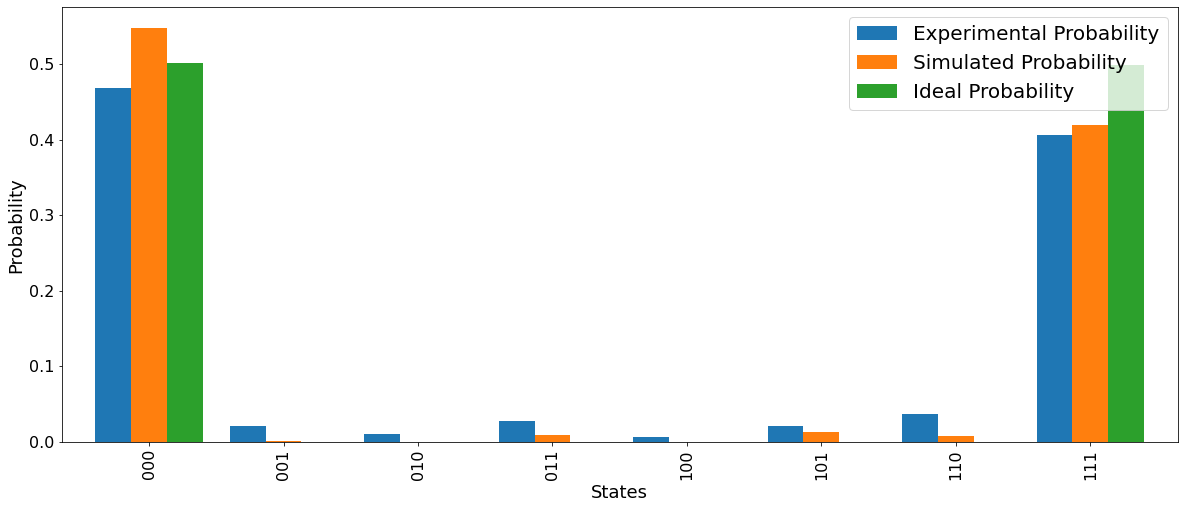

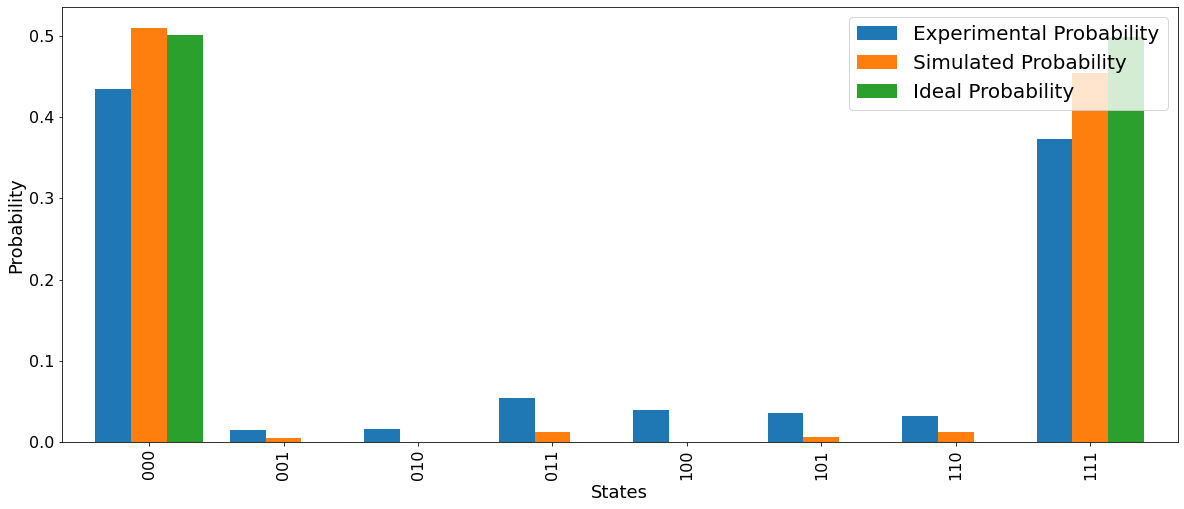

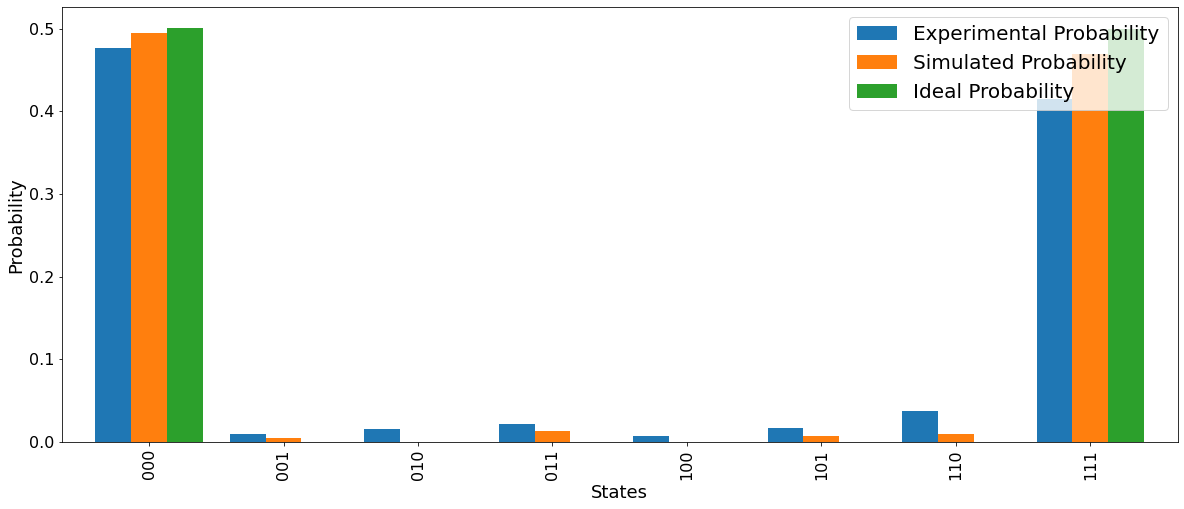

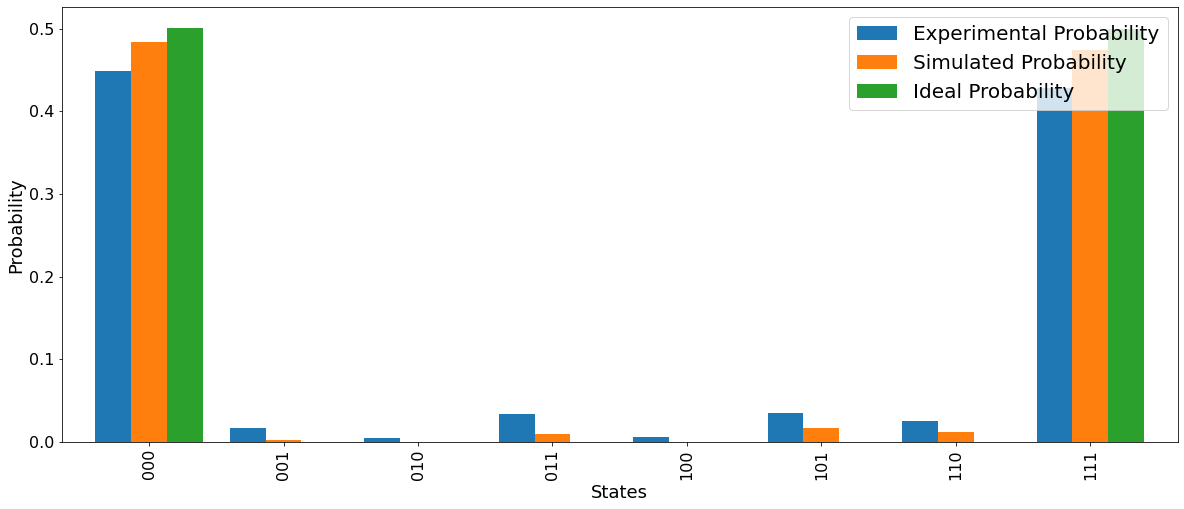

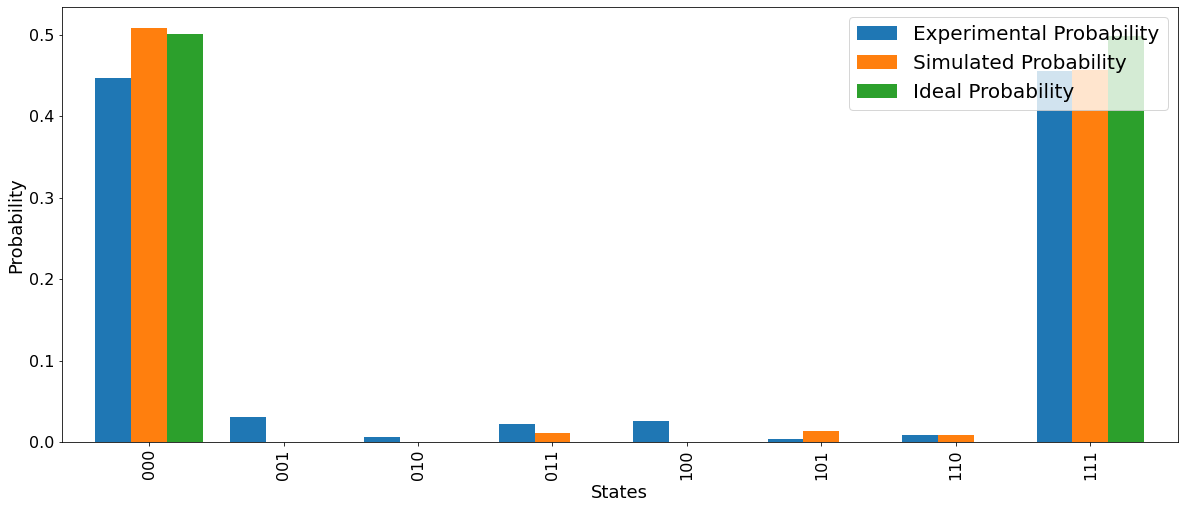

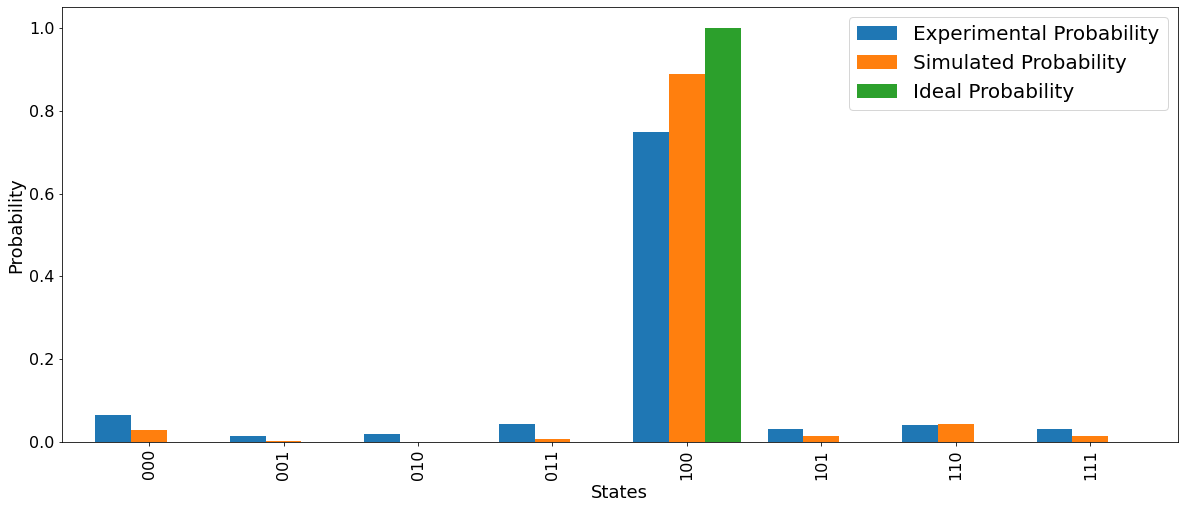

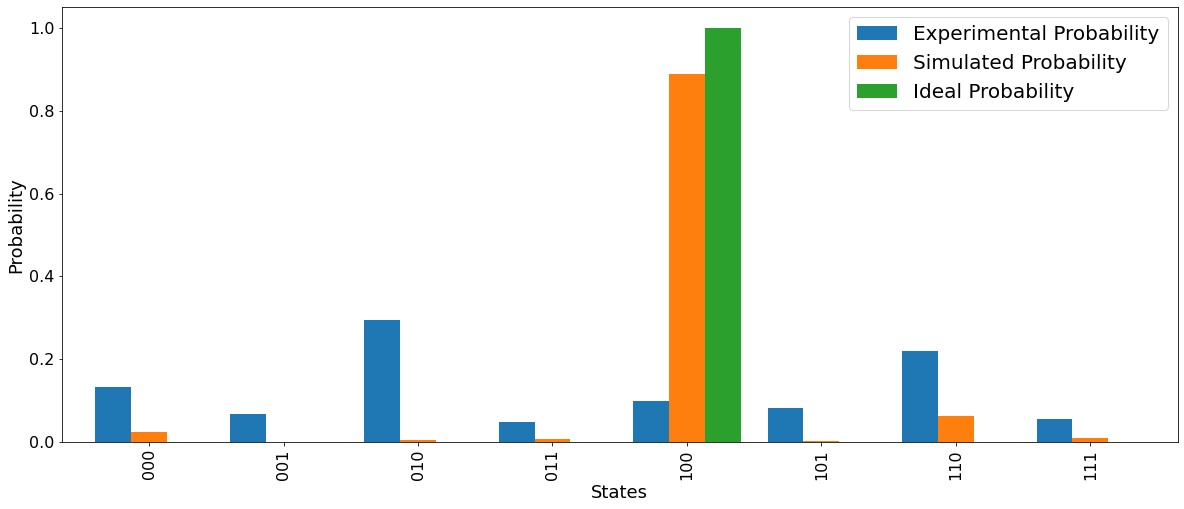

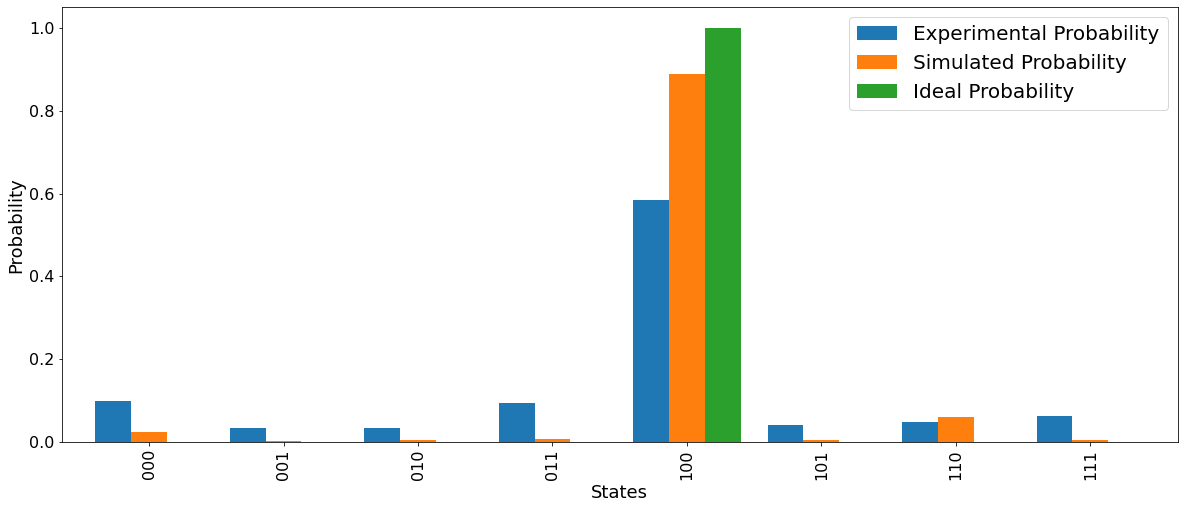

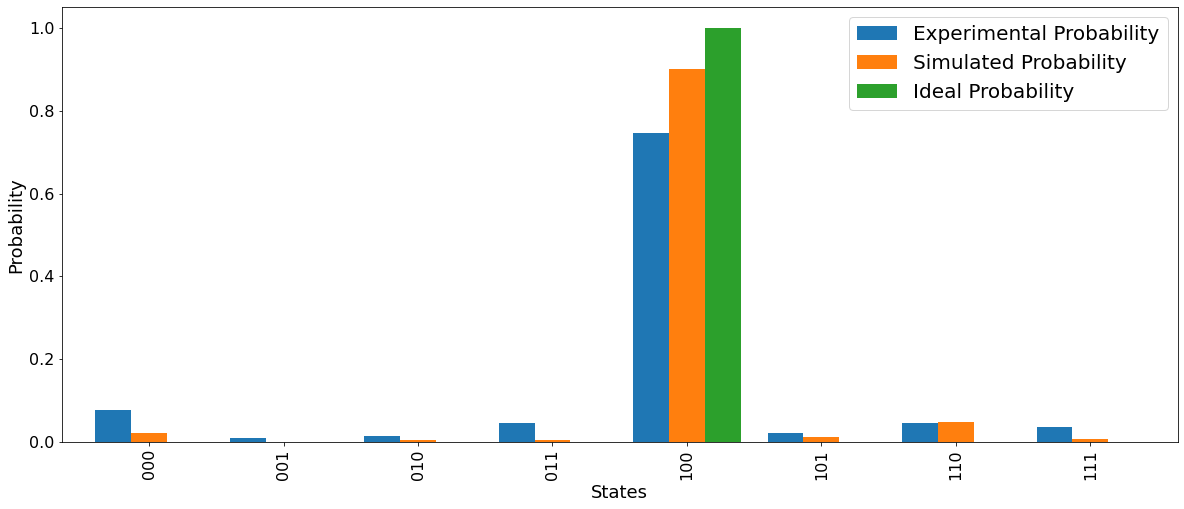

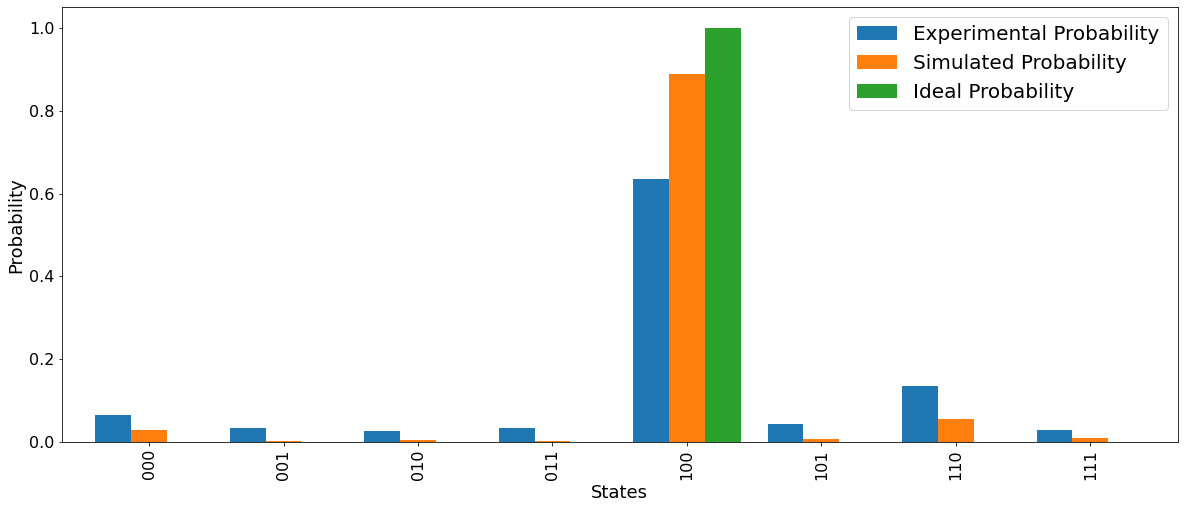

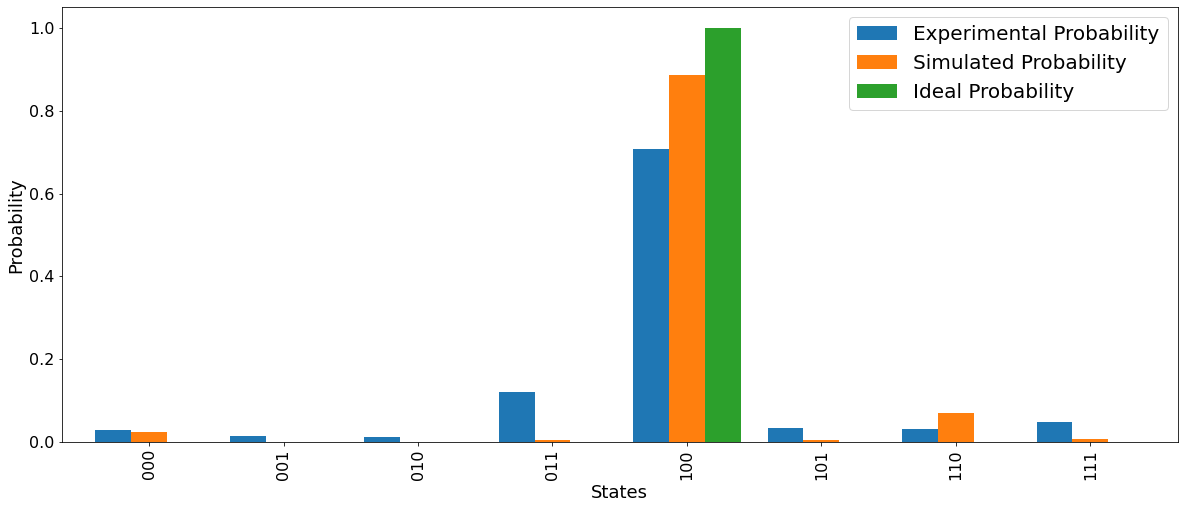

In [110]:
for row in data:
    # print(row[9], row[6], row[8], row[7], row[1], row[2], sep='\n')
    qubits = row[9]
    counts_experimental = convert_string_to_dictionary(row[6])
    counts_simulation = convert_string_to_dictionary(row[8])
    counts_ideal = convert_string_to_dictionary(row[7])
    backend_name = row[1]
    circ_name = row[2]
    
    generate_plot(qubits, counts_experimental, counts_simulation, counts_ideal, backend_name, circ_name)

## Close Connection

In [17]:
con.close()